In [485]:
import json
import os
import random
import re  # Expresiones regulares
import sys  # Interactuar con el sistema
from itertools import chain, combinations  # Iteradores
from pathlib import Path

import geopandas as gpd  # Georeferenciacion
import matplotlib.pyplot as plt  # Visualización de datos
import numpy as np  # Albegra lineal
import osmnx as ox  # OpenStreetMap
import pandas as pd  # Procesamiento de datos
import scipy.stats as stats
import seaborn as sns  # Visualización de datos estadísticos
import sklearn
import utils
from geopandas.datasets import get_path  # Ruta de los datos geográficos
from scipy.stats import chi2_contingency  # Test de chi-cuadrado
from scipy.stats import pearsonr
from shapely.geometry import Point  # Geometría espacial
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score  # Metricas para evaluación
from sklearn.metrics import (confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.notebook import tqdm
from ydata_profiling import ProfileReport

In [486]:
pd.options.mode.chained_assignment = None

random_seed = 42
random.seed(random_seed)

main_path = Path.cwd() / ".."
df = pd.read_csv(main_path / "data/weatherAUS.csv")

spectral_palette = [
    "#9e0142",
    "#d53e4f",
    "#f46d43",
    "#fdae61",
    "#fee08b",
    "#ffffbf",
    "#e6f598",
    "#abdda4",
    "#66c2a5",
    "#3288bd",
    "#5e4fa2",
]

---

#### Data cleansing

Eliminamos las observaciones sin ground truth en la variable objetivo, ya que no van a ser necesarias para el entrenamiento (debido a la gran cantidad de observaciones con las que contamos y la relativamente baja proporción de datos faltantes en la variable objetivo), y tampoco nos van a ser útiles para evaluar el modelo ya que en la immputación podemos introducir ciertos sesgos.

In [487]:
print(
    f"Proporción de datos faltantes en la variable objetivo: {round(df.RainTomorrow.isna().mean(), 3)}"
)

Proporción de datos faltantes en la variable objetivo: 0.022


In [488]:
df = df.dropna(subset=["RainTomorrow"])

---

#### Categorical features encoding

##### Rain Today and Rain Tomorrow

In [489]:
rain_columns = ["RainToday", "RainTomorrow"]
mapping_dict = {"Yes" : 1, "No" : 0}

for column in rain_columns:
    df[column] = df[column].map(mapping_dict)

##### Location

In [490]:
# Geolocate stations
country = "Australia"

mapping_dict = {"Dartmoor": "DartmoorVillage", "Richmond": "RichmondSydney"}
df["Location"] = df["Location"].map(mapping_dict).fillna(df["Location"])

locations = df["Location"].unique()
locations = [re.sub(r"([a-z])([A-Z])", r"\1 \2", l) for l in locations]

locs = []
lats = []
lons = []
for location in locations:
    try:
        lat, lon = ox.geocode(location + f", {country}")

        locs.append(location.replace(" ", ""))
        lats.append(lat)
        lons.append(lon)
    except Exception as e:
        print(f"Error retrieving coordinates for {location}: {e}")

df_locations = pd.DataFrame({"Location": locs, "Lat": lats, "Lon": lons})

df = pd.merge(df, df_locations, how="left", on="Location")

##### Date

In [491]:
df["Date"] = pd.to_datetime(df["Date"])

df['DayOfYear'] = df['Date'].dt.dayofyear
df['DaysInYear'] = df['Date'].dt.is_leap_year.apply(lambda leap: 366 if leap else 365)

df['Angle'] = 2 * np.pi * (df['DayOfYear'] - 1) / (df['DaysInYear'])

df['DayCos'] = np.cos(df['Angle'])
df['DaySin'] = np.sin(df['Angle'])

df = df.drop(columns=["DayOfYear", "DaysInYear", "Angle"])

##### Wind Dir

In [492]:
dirs = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE"]
angles = np.radians(np.arange(0, 360, 22.5))
mapping_dict = {d: a for (d, a) in zip(dirs, angles)}

wind_dir_columns = ["WindGustDir", "WindDir9am", "WindDir3pm"]
for column in wind_dir_columns:
    df[f"{column}Angle"] = df[column].map(mapping_dict)

    df[f"{column}Cos"] = np.cos(df[f"{column}Angle"])
    df[f"{column}Sin"] = np.sin(df[f"{column}Angle"])

    df = df.drop(columns=f"{column}Angle")

---

#### Train Test split

Vamos a utilizar una proporción de 0.7|0.15|0.15 para train, validation and test sets respectivamente. Este split no vamos a realizarlo seleccionadas observaciones completamente al azar, sino que por el contrario vamos a considerar todas las observaciones correspondientes a una serie de fechas seleccionadas al azar. Esto nos permitirá evitar el fenómeno de data leaking dado por un modelo que aprenda que en un determinado día y en un determinado sector geográfico hay lluvia al día siguiente (positivo para la clase objetivo) a partir de observaciones para el mismo día en estaciones cercanas entre si. Recordemos que, cómo vimos en el análisis exploratorio de datos, encontramos estaciones meteorológicas muy cercanas entre si con correlaciones cercanas a 0.8 para la probabilidad de lluvia en un mismo día.

In [493]:
def split_list(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of the split ratios must be 1.0")
    
    random.shuffle(data)

    total_size = len(data)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    
    train_set = data[:train_size]
    val_set = data[train_size:(train_size + val_size)]
    test_set = data[(train_size + val_size):]
    
    return train_set, val_set, test_set

In [494]:
list_dates = df["Date"].unique().tolist()
train_dates, val_dates, test_dates = split_list(list_dates)

train_filt = df["Date"].isin(train_dates + val_dates)
train_set = df.loc[train_filt, :].reset_index(drop=True)

test_filt = df["Date"].isin(test_dates)
test_set = df.loc[test_filt, :].reset_index(drop=True)

---

#### Numeric data transformation

In [495]:
numeric_columns = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm"
]

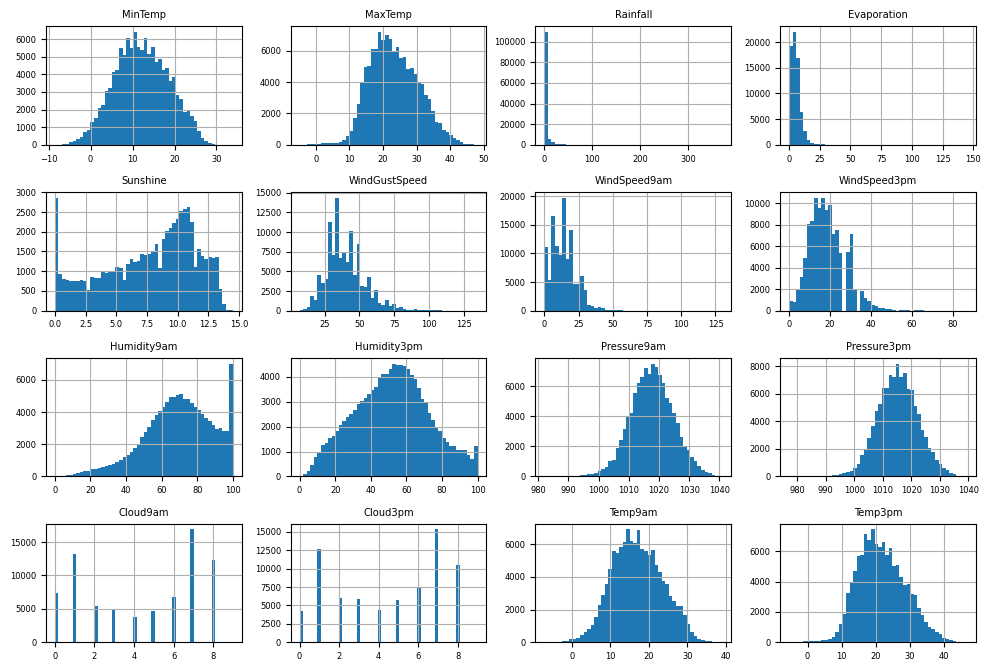

In [496]:
plt.rcParams.update({'font.size': 6})
train_set[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()

In [497]:
train_set[numeric_columns].kurtosis(numeric_only=True)

MinTemp           -0.489722
MaxTemp           -0.237807
Rainfall         185.446037
Evaporation       47.464434
Sunshine          -0.825532
WindGustSpeed      1.409267
WindSpeed9am       1.206857
WindSpeed3pm       0.770985
Humidity9am       -0.045800
Humidity3pm       -0.516242
Pressure9am        0.226843
Pressure3pm        0.107626
Cloud9am          -1.542493
Cloud3pm          -1.458780
Temp9am           -0.349470
Temp3pm           -0.145123
dtype: float64

_Cabe remarcar, que la oblicuidad de la variable Rainfall se debe principalmente al desbalanceo del dataset (mayor cantidad de observaciones con clase negativa para las variables RainToday y RainTomorrow) y la relación determinística entre esta variable cuando asume valor 0 y un valor negativo para la variable RainToday._

Vamos a utilizar la función logarítmica en las variables "Rainfall" y "Evaporation" cuya métrica de oblicuidad es mayor a 2.

In [498]:
right_skewed_columns = ["Rainfall", "Evaporation"]
for column in right_skewed_columns:
    train_set[column] = np.log(train_set[column]+1)

---

#### Missing values imputation

Vamos a realizar la imputación de datos faltantes mediante el algoritmo de KNN

In [499]:
index_columns = ["Date", "Location"]

feature_columns = [
    "Lat",
    "Lon",
    "DayCos",
    "DaySin",
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "WindGustDirCos",
    "WindGustDirSin",
    "WindDir9amCos",
    "WindDir9amSin",
    "WindDir3pmCos",
    "WindDir3pmSin",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
    "RainToday",
]

target_column = ["RainTomorrow"]

In [500]:
significance_thresh = 0.05
corr_thresh = 0.85

locations = df["Location"].unique()
location_pairs = list(combinations(locations, 2))

numeric_feature_columns = [
    x
    for x in feature_columns
    if x not in ["Lat", "Lon", "DayCos", "DaySin", "RainToday"]
]

spatial_correlations = {}
for feature in tqdm(numeric_feature_columns):
    df_feature = train_set.pivot(index="Date", columns="Location", values=feature)

    feature_correlations = []
    for index, location_pair in enumerate(location_pairs):
        loc_a, loc_b = location_pair
        df_feature_pair = df_feature[[loc_a, loc_b]].dropna()
        if not df_feature_pair.empty:
            corr, pvalue = pearsonr(df_feature_pair[loc_a], df_feature_pair[loc_b])

            if (pvalue < significance_thresh) & (corr > corr_thresh):
                ridge = Ridge(alpha=1.0)
                ridge.fit(df_feature_pair[loc_a].values.reshape(-1, 1), df_feature_pair[loc_b])
                intercept = ridge.intercept_
                coeficient = ridge.coef_[0]

                pair_correlation = {}
                pair_correlation["loc_a"] = loc_a
                pair_correlation["loc_b"] = loc_b
                pair_correlation["corr"] = corr
                pair_correlation["intercept"] = intercept
                pair_correlation["slope"] = coeficient
                feature_correlations.append(pair_correlation.copy())

                pair_correlation_inv = {}
                pair_correlation_inv["loc_a"] = loc_b
                pair_correlation_inv["loc_b"] = loc_a
                pair_correlation_inv["corr"] = corr
                pair_correlation_inv["intercept"] = -1 * intercept / coeficient
                pair_correlation_inv["slope"] = 1 / coeficient
                feature_correlations.append(pair_correlation_inv.copy())

    df_feature_correlations = pd.DataFrame(feature_correlations)
    spatial_correlations[feature] = df_feature_correlations

  0%|          | 0/22 [00:00<?, ?it/s]

---

In [501]:
feature = "Sunshine"
spatial_correlations[feature].sort_values(by="corr", ascending=False)

,loc_a,loc_b,corr,intercept,slope
0,Sydney,SydneyAirport,1.000000,0.000194,0.999973
7,Watsonia,Melbourne,1.000000,-0.000217,1.000034
1,SydneyAirport,Sydney,1.000000,-0.000194,1.000027
10,Portland,MountGambier,1.000000,0.000202,0.999969
9,DartmoorVillage,Portland,1.000000,-0.000208,1.000033
8,Portland,DartmoorVillage,1.000000,0.000208,0.999967
11,MountGambier,Portland,1.000000,-0.000202,1.000031
6,Melbourne,Watsonia,1.000000,0.000217,0.999966
5,Watsonia,MelbourneAirport,1.000000,-0.000163,1.000025
4,MelbourneAirport,Watsonia,1.000000,0.000162,0.999975


In [502]:
loc_a, loc_b = ("Nuriootpa", "Adelaide")
df_feature = train_set.pivot(index="Date", columns="Location", values=feature)
df_feature_loc1_loc2 = df_feature[[loc_a, loc_b]].dropna()

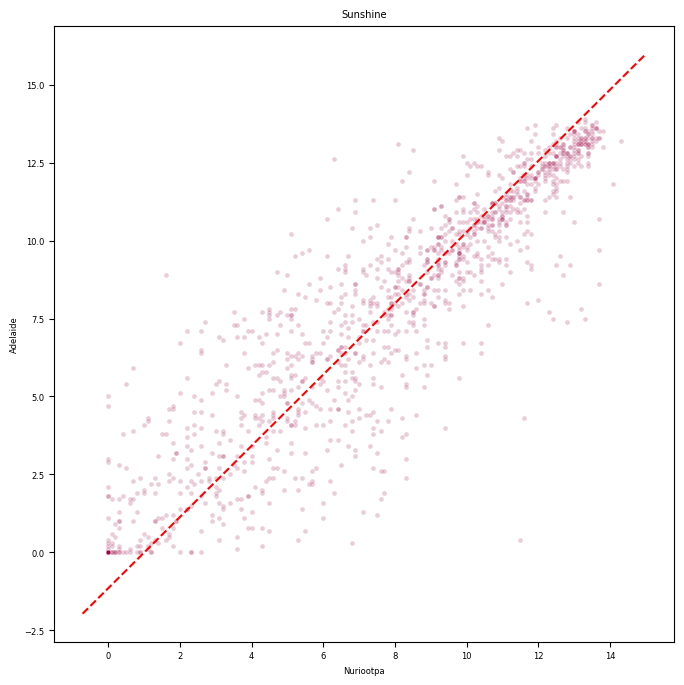

In [503]:
plt.figure(figsize=(8, 8))

sc = plt.scatter(
    df_feature_loc1_loc2[loc_a],
    df_feature_loc1_loc2[loc_b],
    s=12,
    c=spectral_palette[0],
    alpha=0.2,
    edgecolors="w",
    linewidth=0.5,
)

filt = (spatial_correlations[feature]["loc_a"] == loc_a) & (
    spatial_correlations[feature]["loc_b"] == loc_b
)
intercept = spatial_correlations[feature].loc[filt, :]["intercept"].values
slope = spatial_correlations[feature].loc[filt, :]["slope"].values
x_vals = np.array(plt.gca().get_xlim())  # Get current x-axis limits
y_vals = intercept + slope * x_vals  # Calculate corresponding y values
plt.plot(x_vals, y_vals, "--", color="red")  # Plot the line

plt.xlabel(loc_a)
plt.ylabel(loc_b)
plt.title(feature)

plt.show()

---

In [504]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120872 entries, 0 to 120871
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            120872 non-null  datetime64[ns]
 1   Location        120872 non-null  object        
 2   MinTemp         120328 non-null  float64       
 3   MaxTemp         120601 non-null  float64       
 4   Rainfall        119696 non-null  float64       
 5   Evaporation     69171 non-null   float64       
 6   Sunshine        63256 non-null   float64       
 7   WindGustDir     112987 non-null  object        
 8   WindGustSpeed   113039 non-null  float64       
 9   WindDir9am      112458 non-null  object        
 10  WindDir3pm      117684 non-null  object        
 11  WindSpeed9am    119747 non-null  float64       
 12  WindSpeed3pm    118671 non-null  float64       
 13  Humidity9am     119363 non-null  float64       
 14  Humidity3pm     117827 non-null  flo

In [505]:
previous_na = train_set.isna()

In [506]:
def impute_missing(df, date, location, feature, correlations, k):
    filt = correlations["loc_b"] == location
    correlations = correlations.loc[filt, :]

    filt = (
        (df["Date"] == date)
        & (df["Location"].isin(correlations["loc_a"]))
        & (~df[feature].isna())
    )
    if filt.sum() == 0:
        return np.nan
    df_nearests = df.loc[filt, :]

    df_nearests = (
        pd.merge(
            df_nearests[["Date", "Location", feature]],
            correlations[["loc_a", "corr", "intercept", "slope"]],
            how="left",
            left_on="Location",
            right_on="loc_a",
        )
        .sort_values(by="corr", ascending=False)
        .head(3)
    )

    df_nearests["y"] = (
        df_nearests[feature] * df_nearests["slope"] + df_nearests["intercept"]
    )

    imputed = (df_nearests["y"] * (df_nearests["corr"] ** 2)).sum() / (
        df_nearests["corr"] ** 2
    ).sum()

    min_value = df[feature].min()
    max_value = df[feature].max()
    imputed = imputed if imputed > min_value else min_value
    imputed = imputed if imputed < max_value else max_value

    return imputed

In [507]:
for feature in tqdm(numeric_feature_columns):
    feature_locations = spatial_correlations[feature]["loc_a"].unique()

    filt = (train_set[feature].isna()) & (train_set["Location"].isin(feature_locations))
    train_set.loc[filt, feature] = train_set.loc[filt, :].apply(
        lambda x: impute_missing(
            df=train_set,
            date=x["Date"],
            location=x["Location"],
            feature=feature,
            correlations=spatial_correlations[feature],
            k=3,
        ),
        axis=1,
    )

  0%|          | 0/22 [00:00<?, ?it/s]

In [508]:
numeric_feature_columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'WindGustDirCos',
 'WindGustDirSin',
 'WindDir9amCos',
 'WindDir9amSin',
 'WindDir3pmCos',
 'WindDir3pmSin',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [509]:
feature = "Sunshine"
filt = (~train_set[feature].isna())
train_set.loc[filt, :][feature]

5050      12.3
5051      13.0
5052      10.6
5053      12.2
5054       8.4
          ... 
118231    11.0
118232     8.6
118233    11.0
118234    10.6
118235    10.7
Name: Sunshine, Length: 64470, dtype: float64

In [510]:
(train_set[feature].isna()).sum()

56402

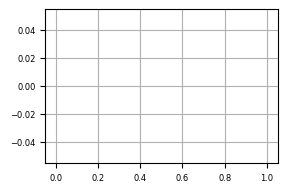

In [511]:
train_set.loc[~filt, :][feature].hist(bins=50, figsize=(3, 2))
plt.show()

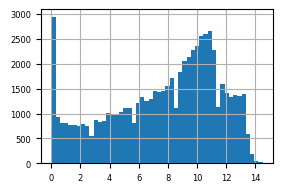

In [512]:
train_set.loc[filt, :][feature].hist(bins=50, figsize=(3, 2))
plt.show()

In [513]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120872 entries, 0 to 120871
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            120872 non-null  datetime64[ns]
 1   Location        120872 non-null  object        
 2   MinTemp         120859 non-null  float64       
 3   MaxTemp         120846 non-null  float64       
 4   Rainfall        119979 non-null  float64       
 5   Evaporation     69171 non-null   float64       
 6   Sunshine        64470 non-null   float64       
 7   WindGustDir     112987 non-null  object        
 8   WindGustSpeed   113806 non-null  float64       
 9   WindDir9am      112458 non-null  object        
 10  WindDir3pm      117684 non-null  object        
 11  WindSpeed9am    119747 non-null  float64       
 12  WindSpeed3pm    118671 non-null  float64       
 13  Humidity9am     119752 non-null  float64       
 14  Humidity3pm     118813 non-null  flo

In [514]:
posterior_na = train_set.isna()

In [516]:
previous_na.sum().sum()

307467

In [518]:
posterior_na.sum().sum() / previous_na.sum().sum()

0.9545674820387229